In [1]:
import os
from dotenv import load_dotenv
import ccxt
import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

In [2]:
# Load environment variables from .env file
load_dotenv()

# Initialize the Binance exchange object
exchange = ccxt.binance({
    'apiKey': os.getenv('API_KEY'),
    'secret': os.getenv('API_SECRET'),
})

In [3]:
crypto = "NFP"
symbol = f'{crypto}/USDT'

start_date = "2024-01-01"
end_date = datetime.now()
timeframe = "15m"

days = pd.date_range(start=start_date, end=end_date, freq='D').tolist()
days_timestamp = [int(datetime.timestamp(day)) * 1000 for day in days]

df = pd.DataFrame(columns=['datetime', 'open', 'high', 'low', 'close', 'volume'])

for day in days_timestamp:
    ohlcv = exchange.fetch_ohlcv(symbol, since=day, limit=96, timeframe=timeframe)
    new_df = pd.DataFrame(ohlcv, columns=['datetime', 'open', 'high', 'low', 'close', 'volume'])
    if not new_df.empty:
        df = pd.concat([df, new_df], ignore_index=True)

df['datetime'] = pd.to_datetime(df['datetime'], unit='ms')
df['datetime'] += pd.Timedelta(hours=1)
df = df.dropna()
df.set_index('datetime', inplace=True)

C:\Users\alexo\AppData\Local\Temp\ipykernel_17936\2801887302.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_df], ignore_index=True)


In [4]:
df["hourly"] = np.array([int(s[-8:-6]) for s in df.index.strftime('%Y-%m-%d %H:%M:%S')])
df.to_csv(f"data/{crypto}.csv")

In [5]:
df["Gap (%)"] = (df["close"] / df["open"] - 1) * 100
df

,open,high,low,close,volume,hourly,Gap (%)
datetime,,,,,,,
2024-01-01 00:00:00,0.89982,0.92109,0.88608,0.88751,926292.0,0,-1.368051
2024-01-01 00:15:00,0.88740,0.89057,0.86501,0.88484,1210286.0,0,-0.288483
2024-01-01 00:30:00,0.88484,0.89731,0.88351,0.89686,637554.0,0,1.358438
2024-01-01 00:45:00,0.89602,0.90998,0.89000,0.90575,459270.0,0,1.085913
2024-01-01 01:00:00,0.90494,0.91500,0.88021,0.88763,1113789.0,1,-1.912834
...,...,...,...,...,...,...,...
2024-02-26 23:15:00,0.74240,0.74286,0.72949,0.73508,611326.0,23,-0.985991
2024-02-26 23:30:00,0.73494,0.73700,0.73165,0.73467,103062.0,23,-0.036738
2024-02-26 23:45:00,0.73467,0.73940,0.73430,0.73457,300280.0,23,-0.013612


In [6]:
df_hourly = pd.DataFrame(df[["hourly", "Gap (%)"]])
df_hourly = df_hourly.groupby("hourly")["Gap (%)"].mean()
df_hourly = pd.DataFrame(df_hourly)
df_hourly

,Gap (%)
hourly,
0,0.035363
1,-0.066207
2,-0.020172
3,0.090194
4,0.046016
5,-0.001770
6,0.065931
7,0.058160
8,-0.014496


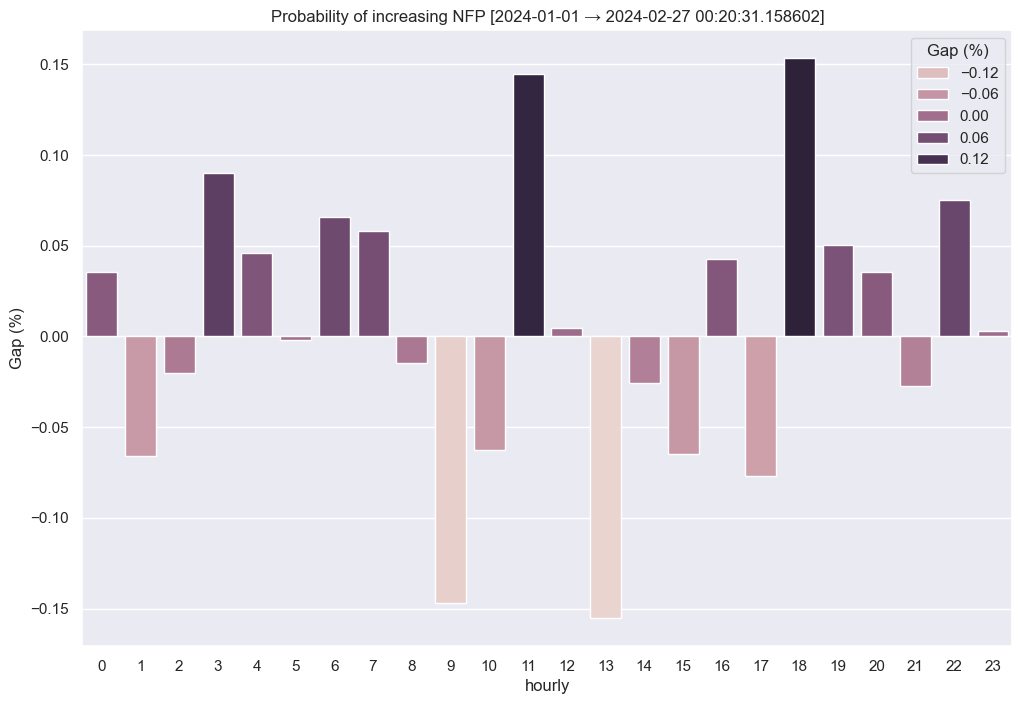

In [7]:
plt.figure(figsize=(12, 8))
sns.barplot(df_hourly, x="hourly", y="Gap (%)", hue="Gap (%)")
plt.title(f"Probability of increasing {crypto} [{start_date} → {end_date}]")
plt.show()

In [8]:
df_hourly_chg_beta = pd.DataFrame(df[["hourly", "Gap (%)"]])
df_hourly_chg_beta["Changement +"] = df_hourly_chg_beta["Gap (%)"] > 0
df_hourly_chg = pd.DataFrame(df_hourly_chg_beta.groupby("hourly")["Changement +"].sum())
df_hourly_chg["Changement -"] = (df_hourly_chg_beta.groupby("hourly")["Changement +"].count()
                                 - df_hourly_chg_beta.groupby("hourly")["Changement +"].sum())

df_hourly_chg["Changement +"] /= df_hourly_chg_beta.groupby("hourly")["Gap (%)"].count()
df_hourly_chg["Changement -"] /= df_hourly_chg_beta.groupby("hourly")["Gap (%)"].count()

df_hourly_chg["Changement +"] *= 100
df_hourly_chg["Changement -"] *= 100

df_hourly_chg = df_hourly_chg.reset_index()
df_hourly_chg = pd.melt(df_hourly_chg, id_vars=['hourly'], var_name='Changement', value_name='num_changement (%)')
df_hourly_chg

,hourly,Changement,num_changement (%)
0,0,Changement +,52.608696
1,1,Changement +,50.000000
2,2,Changement +,48.684211
3,3,Changement +,56.140351
4,4,Changement +,46.491228
5,5,Changement +,50.438596
6,6,Changement +,53.070175
7,7,Changement +,51.754386
8,8,Changement +,47.807018
9,9,Changement +,42.982456


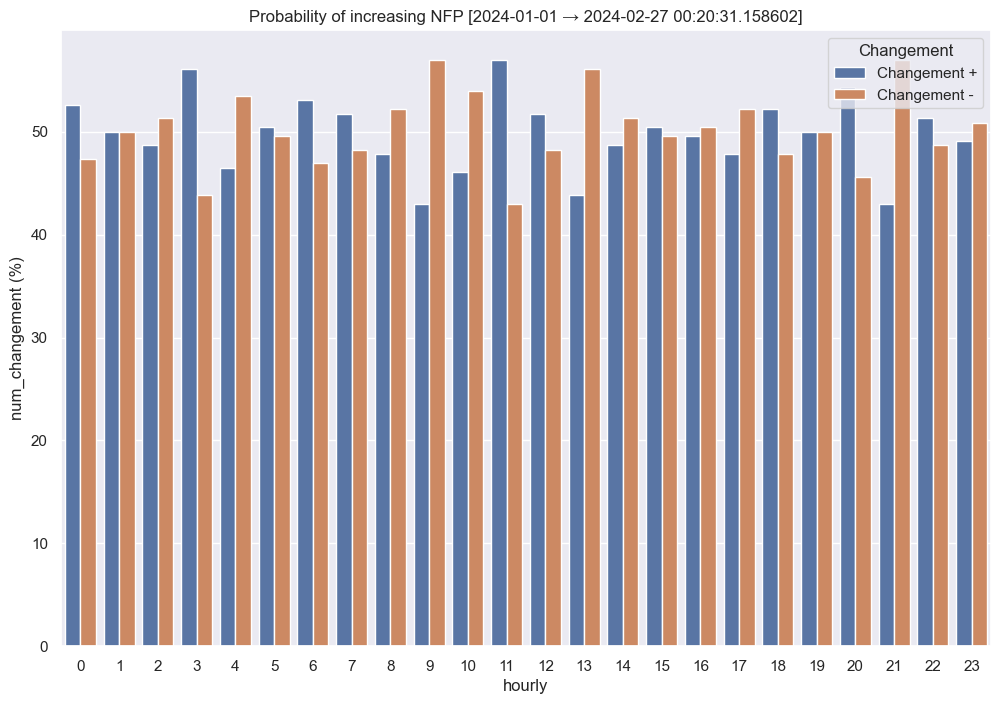

In [9]:
plt.figure(figsize=(12, 8))
sns.barplot(df_hourly_chg, x="hourly", y="num_changement (%)", hue="Changement")
plt.title(f"Probability of increasing {crypto} [{start_date} → {end_date}]")
plt.show()